In [1]:
import math
import random
import numpy as np

In [2]:
class Value:
    def __init__(self, data=1, children=[], _backward=lambda: None):
        self.data = data
        self.children = children
        self._backward = _backward
        self.grad = 0
    
    def log(self):
        def _backward():
            self.grad += (1 / self.data) * out.grad
        out = Value(math.log(self.data), children=[self], _backward=_backward)
        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other))

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def relu(self):
        out = Value(0.1*self.data if self.data < 0 else self.data, children=[self])

        def _backward():
            self.grad += (1 if out.data > 0 else 0.1) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        def _backward():
            self.grad += (1 - pow(out.data, 2)) * out.grad
        out = Value(math.tanh(self.data), children=[self], _backward=_backward)
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other))

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        if isinstance(other, (float, int)):
            def _backward():
                self.grad += other * (self.data ** (other - 1)) * out.grad
            out = Value(self.data ** other, children=[self], _backward=_backward)
        
        elif isinstance(other, Value):
            def _backward():
                self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
                other.grad += math.log(self.data) * (self.data ** other.data) * out.grad
            out = Value(self.data ** other.data, children=[self, other], _backward=_backward)
        
        return out
    
    def __repr__(self):
        return f'data: {self.data}'
    
    def backward(self):
        topo = []
        visited = set()

        def visit(node):
            if node not in visited:
                visited.add(node)
                for children in node.children:
                    visit(children)
                topo.append(node)

        self.grad = 1
        visit(self)
        for item in reversed(topo):
            item._backward()

    def __sub__(self, other):
            return self + (-other)
    
    def __rpow__(self, other):
        if isinstance(other, (float, int)):
            def _backward():
                self.grad += other ** self.data * math.log(other) * out.grad
            out = Value(other ** self.data, children=[self], _backward=_backward)
            return out

    def __rsub__(self, other):
        return other + (-self)

    def __truediv__(self, other):
        if isinstance(other, Value):
            def _backward():
                self.grad += 1 / other.data * out.grad
                other.grad -= self.data / (other.data ** 2) * out.grad
            out = Value(self.data / other.data, children=[self, other], _backward=_backward)
            return out
        elif isinstance(other, (float, int)):
            def _backward():
                self.grad += 1 / other * out.grad
            out = Value(self.data / other, children=[self], _backward=_backward)
            return out


In [3]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
        
    
    def parameters(self):
        return []


class Neuron(Module):

    def __init__(self, nin, nonlinear=True):
        self.w = [Value(random.uniform(-1, 1)*0.01) for _ in range(nin)]
        self.b = Value(0)
        self.nonlinear = nonlinear

    def __call__(self, x):
        out = sum([wi*xi for xi, wi in zip(x, self.w)], self.b)
        return out.tanh() if self.nonlinear else out
    
    def parameters(self):
        return self.w + [self.b]


class Layer(Module):
    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [neuron(x) for neuron in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP(Module):
    def __init__(self, nin, nouts):
        layers = [nin] + nouts
        self.layers = [Layer(layers[i], layers[i+1], nonlinear=(i!=len(nouts)-1)) for i in range(len(layers)-1)]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for neuron in layer.neurons for p in neuron.parameters()]
    
    def equation(self):
        val = ''
        layerEquations = []

        for layer in self.layers:

            neuronEquations = []
            for neuron in layer.neurons:

                equation = ''
                if len(layerEquations) == 0:

                    for w in neuron.w:
                        equation += f'{w.data:.2f}X + '

                else:
                    for w in neuron.w:
                        equation += f'{w.data:.2f}({layerEquations[-1]}) + '

                if neuron.nonlinear:
                    neuronEquations.append(f'tanh({equation}) + {neuron.b.data} + ')
                else:
                    neuronEquations.append(f'{equation}{neuron.b.data} + ')

            fullLayerEquation = ''

            for neuronEquation in neuronEquations:
                fullLayerEquation += neuronEquation

            layerEquations.append(fullLayerEquation)

        for layerEquation in layerEquations:
            val += layerEquation
        
        return val.replace(' + )', '').replace(' + ,', '')[:-3]


In [4]:
import numpy
from tqdm import trange

In [8]:
context_len = 4
feature_count = 20

words = open('../words.txt', 'r').read().splitlines()

chars = sorted(set('.'.join(words)))

itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

X, Y = [], []

for word in words:
    context = [0] * context_len
    word += '.'
    for ch in word:
        X.append(context)
        Y.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

X = np.array(X)
Y = np.array(Y)
model = MLP(27*context_len, [context_len*feature_count, 250, 27])

In [ ]:
lambda_reg = 0.01
batch_size = 8

for _ in (t:=trange(500)):
    batch_loss = 0  # Initialize loss for the batch

    # Accumulate gradients over the batch
    for _ in range(batch_size):
        ix = int(numpy.random.randint(0, X.shape[0], (1,)))

        input = [[0.] * 27 for _ in range(X.shape[1])]

        for i in range(X.shape[1]):
            input[i][int(X[ix][i])] = 1.0

        out = model(np.array(input).flatten())

        expected = Y[ix]

        maxVal = max([num.data for num in out])

        exp = [(2**(num-maxVal)) for num in out]

        count = sum([num.data for num in exp])

        prob = [val/count for val in exp]

        loss = prob[int(Y[ix])].log()*-1
        batch_loss += loss.data  # Accumulate loss

        loss.backward()

    # Update parameters after processing the batch
    for p in model.parameters():
        p.data -= p.grad * 0.05 / batch_size + lambda_reg * p.data**2 
        p.grad = 0
    
    t.set_description(f'Average batch loss: {batch_loss / batch_size:.2f}')

Average batch loss: 3.30:   0%|          | 1/500 [00:10<1:24:37, 10.17s/it]


KeyboardInterrupt: 

In [7]:
ix = int(numpy.random.randint(0, X.shape[0], (1,)))

input = [[0.] * 27 for _ in range(X.shape[1])]

for i in range(X.shape[1]):
    input[i][int(X[ix][i])] = 1.0

out = model(np.array(input).flatten())
expected = Y[ix]

maxVal = max([num.data for num in out])

exp = [(2**(num-maxVal)) for num in out]


count = sum([num.data for num in exp])

prob = [val/count for val in exp]

loss = prob[int(Y[ix])].log()*-1

predict = (0, 0)
for i, p in enumerate(prob):
    if p.data > predict[1]:
        predict = (i, p.data)

print(f'predicted: {predict}, actual: {expected}')

predicted: (9, 0.037340510989433515), actual: 14


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import trange

In [328]:
model = MLP(10, [1])

In [329]:
minRange = -0.5
maxRange = 0.5

In [330]:
X = np.linspace(minRange, maxRange, 100)
Y = np.linspace(minRange, maxRange, 100)
A = np.linspace(minRange, maxRange, 100)
B = np.linspace(minRange, maxRange, 100)
C = np.linspace(minRange, maxRange, 100)
D = np.linspace(minRange, maxRange, 100)
E = np.linspace(minRange, maxRange, 100)
F = np.linspace(minRange, maxRange, 100)
G = np.linspace(minRange, maxRange, 100)
H = np.linspace(minRange, maxRange, 100)

random.shuffle(X)
random.shuffle(Y)
random.shuffle(A)
random.shuffle(B)
random.shuffle(C)
random.shuffle(D)
random.shuffle(E)
random.shuffle(F)
random.shuffle(G)
random.shuffle(H)


def Z(x, y, a, b, c, d, e, f, g, h):
    return x + 33*y + 2*a + 3*b + 4*c + 5*d + 6*e + 33*f - 10*g + 0.5*h + 3

In [377]:
random.shuffle(X)
random.shuffle(Y)
random.shuffle(A)
random.shuffle(B)
random.shuffle(C)
random.shuffle(D)
random.shuffle(E)
random.shuffle(F)
random.shuffle(G)
random.shuffle(H)

for _ in (t:=trange(100)):
    loss_avg = 0
    for x in X[:2]:
        for y in Y[:2]:
            for a in A[:2]:
                for b in B[:2]:
                    for c in C[:2]:
                        for d in D[:2]:
                            for e in E[:2]:
                                for f in F[:2]:
                                    for g in G[:2]:
                                        for h in H[:2]:
                                            out = model([x, y, a, b, c, d, e, f, g, h])

                                            loss = (out-Z(x, y, a, b, c, d, e, f, g, h))**2

                                            loss_avg += loss.data

                                            loss.backward()

                                            for p in model.parameters():
                                                p.data -= 0.001 * p.grad
                                                p.grad = 0

    t.set_description(f'{loss_avg / (X.shape[0]*Y.shape[0])}')

3.7766179188912785e-06: 100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


In [325]:
ix = np.random.randint(-1000, 1000, (1,))
iy = np.random.randint(-1000, 1000, (1,))
ia = np.random.randint(-1000, 1000, (1,))
ib = np.random.randint(-1000, 1000, (1,))
ic = np.random.randint(-1000, 1000, (1,))
id = np.random.randint(-1000, 1000, (1,))
ie = np.random.randint(-1000, 1000, (1,))
iff = np.random.randint(-1000, 1000, (1,))
ig = np.random.randint(-1000, 1000, (1,))
ih = np.random.randint(-1000, 1000, (1,))

out = model([ix, iy, ia, ib, ic, id, ie, iff, ig, ih])

print(f'diff: {out-Z(ix, iy, ia, ib, ic, id, ie, iff, ig, ih)}')

# loss = (out-z)**2

diff: data: [0.00035533]


(100, 100)


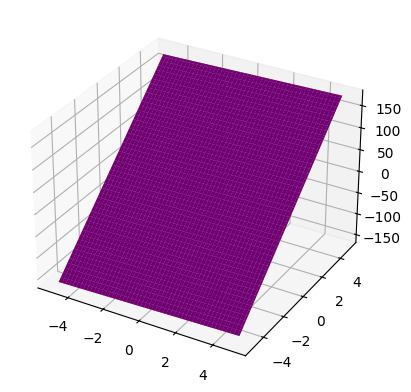

In [169]:
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)

X, Y = np.meshgrid(X, Y)

Z_predicted = np.array([model([x, y]).data for x, y in zip(X.flatten(), Y.flatten())])

# Reshape Z_predicted to match the shape of X and Y
Z_predicted = Z_predicted.reshape(X.shape)

print(Z_predicted.shape)

Z = X + 33*Y + 8

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_predicted, color='red', label='Predicted Z')
ax.plot_surface(X, Y, Z, alpha=0.5, color='blue', label='Actual Z')